In [1]:
from sklearn.datasets import make_moons, make_circles
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

def plot_2Ddata_with_boundary(predict,X,y):
    n = 200
    mins,maxs = np.min(X,axis=0), np.max(X,axis=0)
    mins -= np.abs(mins)*.2
    maxs += np.abs(maxs)*.2
    d0 = np.linspace(mins[0], maxs[0],n)
    d1 = np.linspace(mins[1], maxs[1],n)
    gd0,gd1 = np.meshgrid(d0,d1)
    D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
    p = (predict(D)*1.).reshape((n,n))
    plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c="blue")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c="red")

## Single layer perceptron

In [2]:
class SLP:
    
    def __init__(self, h_units):
        self.h_units = h_units
        
    def sigm(self, x):
        return 1/(1+np.exp(-x))


    def encode(self, b1, W1, b2, W2): 
        return np.array([b1]+list(W1.flatten())+[b2]+list(W2.flatten()))

    def params_decoded(self):
        t1 = self.cols*self.h_units
        b1 = self.params[0]
        W1 = self.params[1:1+t1].reshape(self.cols, self.h_units)
        b2 = self.params[t1+1]
        W2 = self.params[t1+2:].reshape(self.h_units, 1)
        return b1,W1,b2,W2

    def random_params(self):
        W1 = np.random.random(size=(self.cols,self.h_units))
        b1 = np.random.random()

        W2 = np.random.random(size=(self.h_units,1))
        b2 = np.random.random()
        return self.encode(b1,W1,b2,W2)

    def prob(self, X):
        b1,W1,b2,W2 = self.params_decoded()
        return self.sigm(b2+np.tanh(b1+X.dot(W1)).dot(W2))

    def fit(self, X,y, verbose=False):
        self.cols = X.shape[1]

        y = y.reshape(-1,1) if len(y.shape)==1 else y
        def cost(params):
            self.params = params
            return np.sum ( (self.prob(X) - y)**2 )

        r = minimize(cost, self.random_params(), method="BFGS")        
        self.params = r.x
        self.minizer_result = r
        if verbose:
            for k in ["fun", "message", "nfev", "nit", "njev", "status", "success", "x"]:
                print "%10s:"%k, r[k]
        
    def predict(self, X):
        return (self.prob(X)>.5)*1

    def score(self, X,y):
        y = y.reshape(-1,1) if len(y.shape)==1 else y        
        return np.sum(self.predict(X)==y)*1./len(X)


now we fit parameters for sample synthetic dataset. observe that sometimes the minimizer cannot tell whether it has converged. having derivatives would probably help.

In [3]:
X,y = make_moons(200, noise=.2)
slp = SLP(h_units=5)
slp.fit(X,y, verbose=True)

       fun: 2.00001820693
   message: Desired error not necessarily achieved due to precision loss.
      nfev: 3545
       nit: 92
      njev: 186
    status: 2
   success: False
         x: [-229.59845125  203.87994656 -253.03276762 -484.09027708  622.2288604
  238.51121735 -308.34355217   -2.18429926  372.15348786   73.04354492
  224.79743283  235.50057141  569.43381183   48.83570362 -326.76134548
 -264.47676135 -320.48442341]


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp


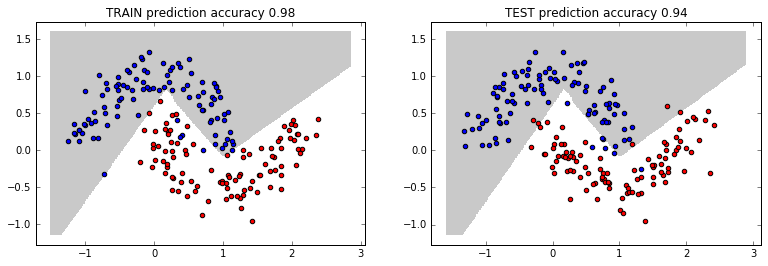

In [4]:
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.title("TRAIN prediction accuracy %.2f"%slp.score(X,y))
plot_2Ddata_with_boundary(slp.predict, X,y)
plt.subplot(122)
Xtest,ytest = make_moons(200, noise=.2)
plt.title("TEST prediction accuracy %.2f"%slp.score(Xtest,ytest))
plot_2Ddata_with_boundary(slp.predict, Xtest,ytest)
          

Optimization terminated successfully.


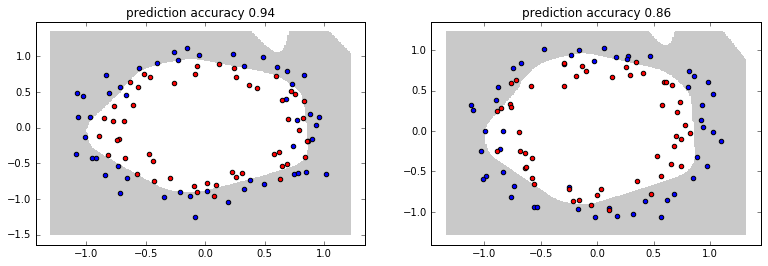

In [5]:
noise = .1
X,y = make_circles(100, noise=noise)
slp = SLP(h_units=10)
slp.fit(X,y)
print slp.minizer_result["message"]
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.title("prediction accuracy %.2f"%slp.score(X,y))
plot_2Ddata_with_boundary(slp.predict, X,y)
plt.subplot(122)
Xtest,ytest = make_circles(100, noise=noise)
plt.title("prediction accuracy %.2f"%slp.score(Xtest,ytest))
plot_2Ddata_with_boundary(slp.predict, Xtest,ytest)


In [6]:
slp.params

array([  -8.86627085,    6.61317137,    3.52388136,    4.77385143,
          7.17946403,    4.87183395,   10.7232576 ,    9.85746847,
          4.41397256,   -7.72941805,   -9.66170017,    3.54176144,
         10.85362585,    1.03848893,    4.08408153,    2.93254101,
          0.66422463,   27.25204507,   -9.94516945,   -8.23787311,
          6.21672665,  -71.27398734,   40.6867351 , -125.06579696,
        212.15330047,   22.88417241,  204.68156102, -176.39003468,
          4.53482917, -229.59381107, -127.79005926, -123.65154538])

### Now, theano version

In [7]:
import theano
import numpy as np
from sklearn.datasets import make_moons
from theano import tensor as T

In [8]:
#X,y = make_moons(200, noise=.2)
X = X.astype(dtype=theano.config.floatX)
y = y.reshape(-1,1).astype(dtype=theano.config.floatX)

In [9]:
tX = T.matrix('X')
ty = T.matrix('y')

In [10]:
h_units = 10
cols = 2
m    = len(X)
rng = np.random.RandomState(np.random.randint(10000))
W1_vals = np.random.random(size=(cols,h_units)).astype(dtype=theano.config.floatX)

W1_vals = np.asarray(
    rng.uniform(
        low=-np.sqrt(6. / (cols + h_units)),
        high=np.sqrt(6. / (cols + h_units)),
        size=(cols, h_units)
    ),
    dtype=theano.config.floatX
)

b1_val  = 0.
W2_vals = np.random.random(size=(h_units,1)).astype(dtype=theano.config.floatX)

W2_vals = np.asarray(
    rng.uniform(
        low=-np.sqrt(6. / (1 + h_units)),
        high=np.sqrt(6. / (1 + h_units)),
        size=(h_units, 1)
    ),
    dtype=theano.config.floatX
)*4


b2_val  = 0.
tW1 = theano.shared(value=W1_vals, name="W1", borrow=True)
tb1 = theano.shared(value=b1_val,  name="b1", borrow=True)
tW2 = theano.shared(value=W2_vals, name="W2", borrow=True)
tb2 = theano.shared(value=b2_val,  name="b2", borrow=True)

In [11]:

learning_rate = .1

#ex = tb2+T.dot(T.tanh(T.dot(tX, tW1)+tb1), tW2)
#cost = (1./(1.+T.exp(-(ex-ty)**2))).sum()

ex = tb2+T.dot(T.tanh(T.dot(tX, tW1)+tb1), tW2)
cost = ((1./(1.+T.exp(-ex)) - ty )**2).mean()

g_W1 = T.grad(cost=cost, wrt=tW1)
g_b1 = T.grad(cost=cost, wrt=tb1)
g_W2 = T.grad(cost=cost, wrt=tW2)
g_b2 = T.grad(cost=cost, wrt=tb2)
updates = [ (tW1, tW1-learning_rate*g_W1),
            (tb1, tb1-learning_rate*g_b1),
            (tW2, tW2-learning_rate*g_W2),
            (tb2, tb2-learning_rate*g_b2)]

In [12]:
y.shape, X.shape

((100, 1), (100, 2))

get compiled evaluable function from symbolic gradient

In [13]:
fg_W1 = theano.function(inputs=[], outputs=g_W1, givens={tX: X,ty: y})

In [14]:
fg_W1()

array([[ 0.06802965, -0.02165964,  0.00974158,  0.07188046,  0.09545479,
         0.0107008 ,  0.05476589, -0.06237306,  0.08124114,  0.03627611],
       [ 0.06456633, -0.01358328,  0.00820652,  0.05782608,  0.05917165,
         0.00682494,  0.04816492, -0.04128256,  0.06122948,  0.02769351]])

In [15]:
train_model = theano.function(
    inputs=[],
    outputs=cost,
    updates=updates,
    givens={tX: X,ty: y}
)

In [16]:
train_model()

array(0.29820446848331494)

In [17]:
for i in range(10000):
     train_model()

train_model()

array(0.12168485038969776)

check 0.121682883803
aaccuracy 0.85


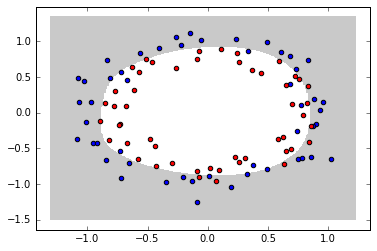

In [18]:
#self.sigm(b2+np.tanh(b1+X.dot(W1)).dot(W2))
#np.sum(b2_val+np.dot(np.tanh(np.dot(X, W1_vals)+b2_val),W2_vals))
b1 = tb1.get_value()
b2 = tb2.get_value()
W1 = tW1.get_value()
W2 = tW2.get_value()
print "check", np.mean(((1./(1+np.exp(-(b2+np.dot(np.tanh(np.dot(X,W1)+b1), W2)))))-y)**2)

slp = SLP(h_units=h_units)
slp.cols = X.shape[1]
slp.params = slp.encode(tb1.get_value(), tW1.get_value().astype(float), 
                        tb2.get_value(), tW2.get_value().astype(float))
print "aaccuracy", slp.score(X,y)
plot_2Ddata_with_boundary(slp.predict, X,y.flatten())

In [19]:
slp = SLP(h_units=h_units)
slp.cols = X.shape[1]

0.85


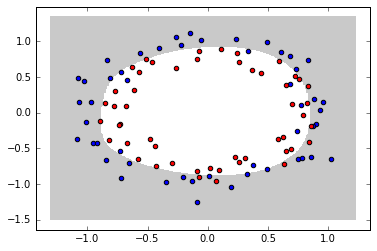

In [21]:
slp = SLP(h_units=h_units)
slp.cols = X.shape[1]
slp.params = slp.encode(tb1.get_value(), tW1.get_value().astype(float), 
                        tb2.get_value(), tW2.get_value().astype(float))
print slp.score(X,y)
plot_2Ddata_with_boundary(slp.predict, X,y.flatten())

Optimization terminated successfully.
0.94


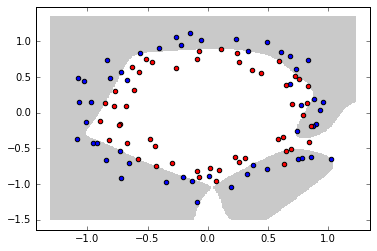

In [23]:
slp = SLP(h_units=h_units)
slp.fit(X,y)
print slp.minizer_result["message"]
print slp.score(X,y)
plot_2Ddata_with_boundary(slp.predict, X,y.flatten())

In [24]:
b1.shape, W1.shape, b2.shape, W2.shape

((), (2, 10), (), (10, 1))

In [25]:
np.sum(slp.sigm((b1+np.tanh( (b1+X.dot(W1)).astype(float)).dot(W2)).astype(float)))

71.109947868374675